In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
from narsil2.mm.segmentation import load_net, segment_cells_dir, segment_all_positions, MMDataTest, segment_channels_dir
from narsil2.segmentation.transformations import OmniTestTransformations, UnetTestTransformations
from narsil2.mm.segmentation import cut_channels_all_positions, cut_fluor_all_positions, cut_fluor_one_position
from narsil2.mm.segmentation import cut_channels_one_position
from narsil2.fish.transformations import FishTransformations
from narsil2.mm.tracking import process_all_positions, process_one_position
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [3]:
root_dir = '/mnt/sda2/Praneeth/ASTFISH/'
phase_main_dir = root_dir + 'data/EXP-22-BZ0300 AST FISH 220422/The run'
analysis_dir = root_dir + 'analysis_rev/EXP-22-BZ0300 AST FISH 220422/'
genotype_dir = root_dir + 'data/EXP-22-BZ0300 AST FISH 220422/Genotype'
positions = list(range(101, 163)) + list(range(201, 263))
#positions = [101]

#### Model paths

In [4]:
cell_seg_path = '../../saved_models/omnipose_mm_old_new_320_long.ckpt'
channel_seg_path = '../../saved_models/channels.pth'
tracker_model_path = '../../saved_models/tracker_model.pth'
fish_model_path = '../../saved_models/seven_species_debugged.joblib'

### Segmentation 

In [5]:


segmentation_parameters = {
    'fileformat': "*.tiff",
    'seg_method': {
        'cells': 'omnipose',
        'channels': 'unet'
    },
    'cell_transforms': OmniTestTransformations(return_tensors=True, shrink_half=False),
    'channel_transforms': UnetTestTransformations(return_tensors=True,
                                                  shrink_half=False,
                                                  pad_to=16,
                                                  add_noise=True,
                                                  flip=False),
    'channel_add_noise': True,
    'clean_mask': False,
    'cell_prob_threshold': 0.3,
    'channel_seg_threshold': 0.7,
    'min_size': 400,
    'save_seg_mask': True,
    'save_channel_seg_mask': False,
    'save_seg_dir': None,
    'model_paths': {
        'cells': cell_seg_path,
        'channels': channel_seg_path
    },
    'segmentation_devices': {
        'cells': 'cuda:1', # cell net takes more space so you will have to run it on cuda:1
        'channels': 'cuda:0' # channel net is smaller so you can run it independently in a different process.
    },
    'channel_cutting_params': {
        'channel_min': 600,
        'channel_max': 1200,
        'channel_sum': 300,
        'hist_peaks_distance': 90,
        'minimum_barcode_distance': 160,
        'num_channels': 16,
        'first_barcode_index': 10,
    },
    'flip_positions': range(201, 263),
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'cell_seg_raw': 'segmented_phase',
        'channel_seg_raw': 'segmented_channels',
        'channel_stacks' : 'blobs',
        'fluor_stacks': 'fish_channels',
    },
    'dir_names': {
        'phase': 'phase'
    },
    'cutting_and_writing_params' : {
        'num_images': 29,
        'channel_width': 80,
        'cut_until_frames': 29,
        
    }
    
}

#### Uncomment and run the next cell to do segmentation

In [6]:
#segment_all_positions(phase_main_dir, segmentation_parameters, positions)

In [7]:
fluorescence_parameters = {
    'channel_names': ['alexa488', 'cy3', 'cy5', 'texasred'],
    'channel_width': 80,
    'flip_positions': range(201, 263),
    'transform': FishTransformations(return_tensors=False, pad_to=16, shrink_half=False, flip=False),
    'phase_img_to_map': 'img_000000028.tiff', # ususally the last image in the stack,
    'equalize': None,
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'fluor_stacks': 'fish_channels',
    },
    'genotype_dir': genotype_dir, 
}

#### Cut channels and write channel stacks

In [8]:
#cut_channels_all_positions(analysis_dir, positions, segmentation_parameters)

#### Cut fluor channels and write them

In [9]:
#cut_fluor_all_positions(analysis_dir, positions, fluorescence_parameters)

#### Tracking and growth calculations

In [10]:
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': tracker_model_path,
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 281),
    'num_channels': 32,
    'growth_type': 'rolling'
}
fluor_parameters = {
    'channel_names':  ['alexa488', 'cy3', 'cy5', 'texasred'],
    'classifier_path': fish_model_path,
    'normalization_vector': np.array([4355.27135471, 4455.60567133, 4420.70555397, 4186.88742982]),
    'smooth': True,
}
positions = list(range(101, 163)) + list(range(201, 263))

In [11]:
#analysis_position_dir = Path(analysis_dir) / 'Pos101'

In [12]:
#process_one_position(analysis_position_dir, tracking_parameters, fluor_parameters, process_type='double')

#### Track, assign species and write growth rates

In [13]:
#process_all_positions(Path(analysis_dir), positions,
#                    tracking_parameters, fluor_parameters,
#                    process_type='double')

### Growth rates plots

In [14]:
from narsil2.mm.growth import growth_rate_pickles


In [15]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirbalis', 'S.aureus']
No_Ab_Positions = list(range(101, 163))
Ab_Positions = list(range(201, 263))

In [16]:
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=4,
                        antibiotic_name='Vancomycin',
                       n_frames=29)

In [17]:
g.No_Ab_Clean_GrowthRates

{'ecoli': (array([0.        , 0.        , 0.        , 0.        , 0.01496049,
         0.01712336, 0.01878173, 0.01987706, 0.02028836, 0.02048394,
         0.02126539, 0.02104769, 0.01989114, 0.0194686 , 0.0189413 ,
         0.0190779 , 0.01921295, 0.01917148, 0.01941769, 0.01903046,
         0.01879867, 0.01887715, 0.01849515, 0.01902829, 0.01881395,
         0.01886928, 0.01925123, 0.01932172, 0.01973765]),
  array([0.        , 0.        , 0.        , 0.        , 0.00639318,
         0.00637494, 0.00763218, 0.00827483, 0.00777542, 0.0071791 ,
         0.00731217, 0.0073357 , 0.00591512, 0.00517686, 0.00591724,
         0.00618199, 0.00645747, 0.00640643, 0.00632667, 0.00651947,
         0.00580615, 0.00629238, 0.00615984, 0.00648423, 0.00599609,
         0.00601936, 0.00611477, 0.00634757, 0.0061117 ]),
  array([   0.,    0.,    0.,    0.,  827.,  889.,  932.,  984., 1024.,
         1075., 1123., 1174., 1219., 1263., 1306., 1351., 1413., 1501.,
         1554., 1616., 1697., 1775., 18

In [18]:
g.Ab_Clean_GrowthRates

{'ecoli': (array([0.        , 0.        , 0.        , 0.        , 0.01498805,
         0.01771787, 0.0186009 , 0.01941834, 0.0192106 , 0.01998234,
         0.02029943, 0.0204009 , 0.0197139 , 0.01948857, 0.01916411,
         0.01869804, 0.01896393, 0.01862081, 0.01865222, 0.01857154,
         0.01839783, 0.01857461, 0.01848814, 0.01866928, 0.01902915,
         0.01896088, 0.01926515, 0.01905586, 0.01935013]),
  array([0.        , 0.        , 0.        , 0.        , 0.00567077,
         0.00729473, 0.00642959, 0.00648408, 0.00587624, 0.00593169,
         0.00609821, 0.00621916, 0.00591919, 0.00560444, 0.00545628,
         0.00556103, 0.00541669, 0.00520683, 0.00531813, 0.00537774,
         0.00526334, 0.00545065, 0.00545217, 0.00541455, 0.00545944,
         0.00547782, 0.00568318, 0.00577006, 0.00564365]),
  array([   0.,    0.,    0.,    0., 1082., 1152., 1212., 1276., 1332.,
         1379., 1413., 1457., 1499., 1538., 1580., 1632., 1688., 1730.,
         1802., 1877., 1939., 2046., 21

In [19]:
species_full_names = {
    'ecoli':'E.coli',
    'kpneumoniae':'K.pneumoniae',
    'paeruginosa':'P.aeruginosa',
    'efaecalis':'E.faecalis',
    'abaumanii':  'A.baumannii',
    'pmirbalis': 'P.mirabilis',
    'saureus': 'S.aureus',
}

In [20]:
color_scheme = {
    'ecoli': 'c',
    'efaecalis': 'g',
}

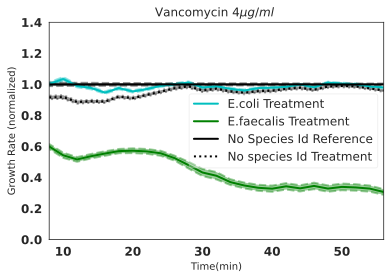

In [21]:
g.plot_species_wise_and_pooled(color_scheme=color_scheme,
                               ignore=['paeruginosa','kpneumoniae' , 'pmirbalis', 'abaumanii', 'saureus'],
                              species_full_name=species_full_names)

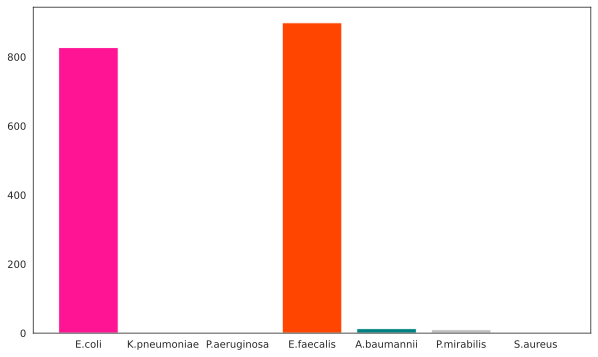

In [22]:
labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(g.No_Ab_Clean_GrowthRates[species][2][4])
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.show()